<h1>Clothes Type Recognition with DeepFashion Dataset and Fast AI</h1>

<p>This Notebook presents a solution for a fine-grained clothing classification problem. The solution implemented using PyTorch and FastAI libraries. The model trained on a Windows machine with GTX 1080Ti Turbo GPU.</p>

In [1]:
from fastai.vision.data import ImageDataLoaders
from fastai.vision.all import *
from fastai.imports import *
import gc 
import pandas as pd

%matplotlib inline

<h2>Data</h2>
<p>The model is trained on a <a href="http://mmlab.ie.cuhk.edu.hk/projects/DeepFashion.html">DeepFashion</a> Dataset, a large-scale clothes database for Clothing Category and Attribute Prediction collected by Multimedia Lab at The Chinese University of Hong Kong. The current benchmark was published in 2016, it evaluates the performance of the FashionNet Model in predicting 46 categories and 1000 attributes of clothes. For original paper please refer to <a href="https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Liu_DeepFashion_Powering_Robust_CVPR_2016_paper.pdf"> DeepFashion: Powering Robust Clothes Recognition and Retrieval with Rich Annotations, CVPR 2016</a>.</p>
<p>The DeepFashion Database contains several datasets. For this project, the Category and Attribute Prediction Benchmark was used. This dataset contains 289,222 diverse clothes images from 46 different categories.</p>

In [46]:
PATH = "fasion-adviser/deepfashion-dataset/"
TRAINING_PATH = "clothes_categories/train_labels.csv"
TEST_PATH = "clothes_categories/test_labels.csv"
CUSTOM_DATASET_PATH = "clothes_categories/test_labels_phone.csv"
CLASSES_PATH = "clothes_categories/classes.txt"

<p>Training data are stored in train_labels.csv. Let's load the file and look at what is inside.</p>

In [3]:
train_df = pd.read_csv(PATH+TRAINING_PATH)
train_df.head(5)

,image_name,category_name
0,img\Sheer_Pleated-Front_Blouse\img_00000001.jpg,Blouse
1,img\Sheer_Pleated-Front_Blouse\img_00000002.jpg,Blouse
2,img\Sheer_Pleated-Front_Blouse\img_00000003.jpg,Blouse
3,img\Sheer_Pleated-Front_Blouse\img_00000004.jpg,Blouse
4,img\Sheer_Pleated-Front_Blouse\img_00000006.jpg,Blouse


<p>The dataset contains the location of the images and the labels as a string object, one label per image.</p>
<p>The data could be loaded with ImageDataLoaders class using from_csv method. We use fastai data augmentation strategy called presizing. For that, we first pass item_tfms=Resize(300), which resizes the image to a smaller square shape to enable all following augmentation happening on GPU. As a next step we pass batch_tfms=aug_transforms(size=224, min_scale=0.9). In this step, the GPU is used for all data augmentation, and all of the potentially destructive operations (like rotation and zoom in) are done together, with a single interpolation at the end. This augmentation strategy will allow us to achieve a better quality of augmented images and gain some speed due to the processing on GPU.</p>

In [64]:
data = ImageDataLoaders.from_csv(PATH, csv_fname=TRAINING_PATH,
                                 item_tfms=Resize(300),
                                 batch_tfms=aug_transforms(size=224, min_scale=0.9),
                                 valid_pct=0.1,
                                 splitter=RandomSplitter(seed=42), #seed=42
                                 num_workers=0)

<p>Let's look at some images in our dataset. As we can see the original dataset incorporates some noise in labels. That will affect the quality of the model.</p>

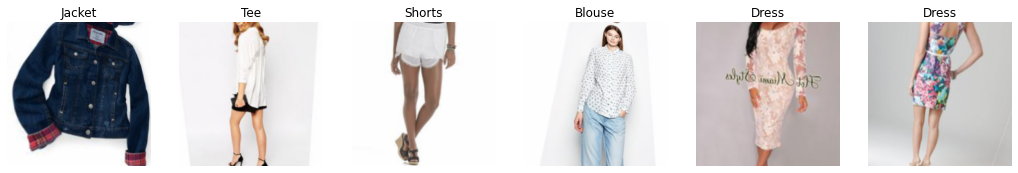

In [54]:
data.show_batch(max_n=6, nrows=1)

<p>We can check how the augmented images look by passing unique=True to show_batch method.</p>

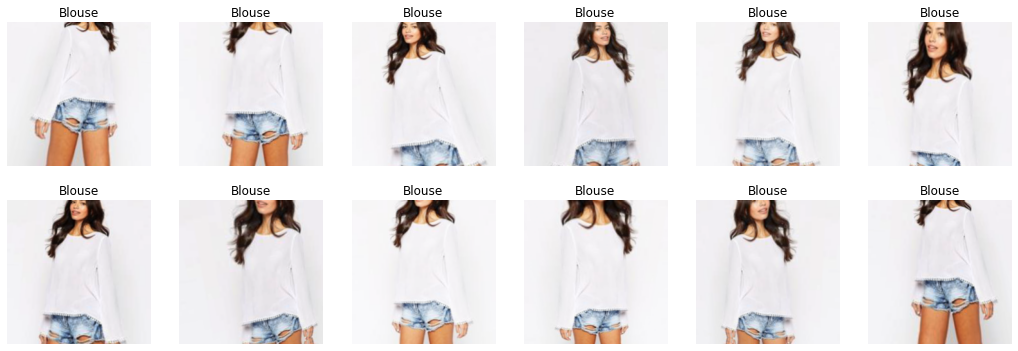

In [65]:
data.show_batch(max_n=12, nrows=2, unique=True)

<h2>Model Training</h2>
<p>Now time to train a classification model. In this project we will use <a href ="https://en.wikipedia.org/wiki/Residual_neural_network">ResNet34</a>.</p>
<p>We will pass the DataLoader that we created in a previous step, use pre-trained ImageNet weights, and accuracy as an evaluation metric.</p>
<h>In this project we want to recognize different types of clothes. Apparently, our classification categories differ from the original classes in the ImageNet dataset which was used to train ResNet34 model. In order to make transfer learning work, we need to replace the last layer of the network with a new linear layer containing the same number of activations as the number of classes in our dataset. In our case we have 46 clothes categories, meaning that we have 46 activations in our new layer. The newly added layer does not contain pre-trained weights and initializes them at random. Therefore our model will have random output before it is trained, which doesn't mean that the model is entirely random. All the other layers that were not changed will preserve the same weights as the original model and will be good in recognizing general visual concepts such as basic geometric figures, gradients, etc. Therefore when we are tuning our model to be able to recognize clothes types we freeze the entire network, but the last layer. That will allow us to optimize the weights of the last layer without changing the weights of the deeper layers.</p>

In [7]:
learn = cnn_learner(data, resnet34, metrics=accuracy, pretrained=True)
learn.fine_tune(2)
learn.save('stage-1_resnet34')

epoch,train_loss,valid_loss,accuracy,time
0,1.583457,1.416678,0.583741,21:19


epoch,train_loss,valid_loss,accuracy,time
0,1.266868,1.163267,0.658013,23:53
1,1.110473,1.035685,0.693925,23:23


Path('fasion-adviser/deepfashion-dataset/models/stage-1_resnet34.pth')

<p>When we call learn.fine_tune(), we freeze the entire network, and train for an epoch only the randomly initialized activations of the newly created layer. Then we unfreeze the network and train all layers together for the number of epochs we specified (in our case two). That is why we see the result for three epochs and not two when calling learn.fine_tune()</p>

In [8]:
gc.collect()
torch.cuda.empty_cache()

<h3>Early Evaluation</h3>

<p>There are multiple ways to look at the result produced by training a neural network. To get a quick impression we can look at the Confusion Matrix.</p>

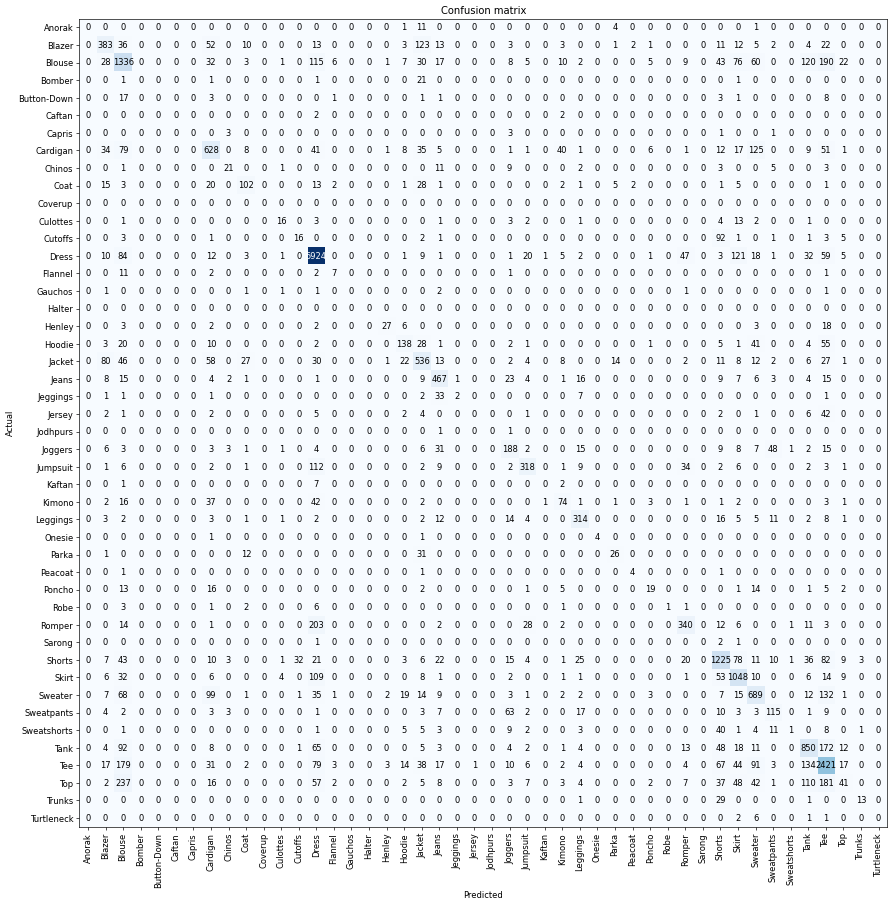

In [9]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(15,15), dpi=60)

<p>Hovewer when we have more than 10 classes the Confusion Matrix is getting convolved and it might be more convenient just to print the most frequently confused classes: </p>

In [10]:
interp.most_confused(min_val=70)

[('Top', 'Blouse', 237),
 ('Romper', 'Dress', 203),
 ('Blouse', 'Tee', 190),
 ('Top', 'Tee', 181),
 ('Tee', 'Blouse', 179),
 ('Tank', 'Tee', 172),
 ('Tee', 'Tank', 134),
 ('Sweater', 'Tee', 132),
 ('Cardigan', 'Sweater', 125),
 ('Blazer', 'Jacket', 123),
 ('Dress', 'Skirt', 121),
 ('Blouse', 'Tank', 120),
 ('Blouse', 'Dress', 115),
 ('Jumpsuit', 'Dress', 112),
 ('Top', 'Tank', 110),
 ('Skirt', 'Dress', 109),
 ('Sweater', 'Cardigan', 99),
 ('Cutoffs', 'Shorts', 92),
 ('Tank', 'Blouse', 92),
 ('Tee', 'Sweater', 91),
 ('Dress', 'Blouse', 84),
 ('Shorts', 'Tee', 82),
 ('Jacket', 'Blazer', 80),
 ('Cardigan', 'Blouse', 79),
 ('Tee', 'Dress', 79),
 ('Shorts', 'Skirt', 78),
 ('Blouse', 'Skirt', 76)]

<p>As we can see the network most often confuses: 'Top' with 'Blouse', 'Romper' with 'Dress', and 'Tee' with 'Blouse'. Those are the mistakes that even a human could make. This way we can quite early evaluate whether our network learns the right pattern.</p>
<p>Another way to look at the errors is to ploy top losses. We can see that the original labels are not perfect and incorporate some noise.</p>

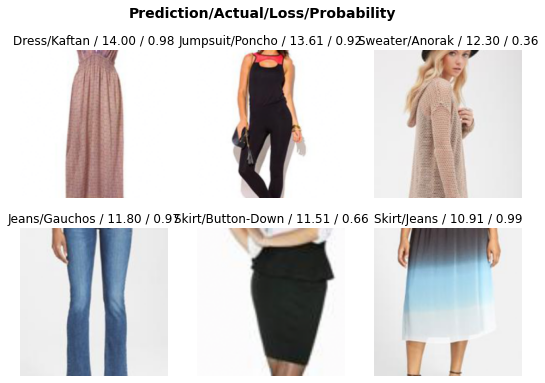

In [11]:
interp.plot_top_losses(6, nrows=2)

<h3>Learning Rate Finder</h3>

<p>Now let's go through the data in our DataLoader and gradually increase the learning rate with each mini-batch to observe how the value of loss changes with the change of learning rate. Our goal is to find the most efficient learning rate that will allow the network to converge faster. This point is the steepest slope of the loss curve. The points of extremums (min and max) and flat parts of the curve correspond to the learning rates that do not allow the network to learn, as the loss at these points does not improve.</p>

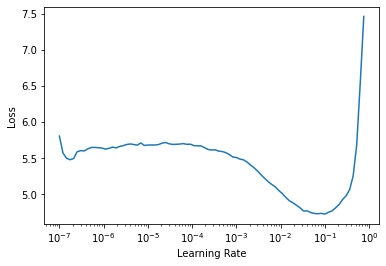

In [12]:
learn = cnn_learner(data, resnet34, metrics=accuracy)
lr_min, lr_steep = learn.lr_find()

<p>In our case the steepest point of the loss curve is at the learning rate equal to 0.005. This learning rate we will use for further training.</p>

In [13]:
print(f"Minimum/10: {lr_min: .2e}, steepest point: {lr_steep: .2e}")

Minimum/10:  1.00e-02, steepest point:  1.10e-02


In [14]:
learn.fine_tune(2, base_lr=5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.504306,1.353271,0.600714,1:33:04


epoch,train_loss,valid_loss,accuracy,time
0,1.293552,1.187417,0.651432,24:17
1,1.132707,1.033418,0.697175,23:27


<p>After training the model for 3 epochs we are getting 0.697 Top-1 Accuracy which is an improvement over 0.694, that we had initially with the default learning rate.</p>
<h3>Discriminative Learning Rates</h3>
<p>After training all layers of the network we need to review the learning rates again, as after a few batches of training with a relatively high learning rate the old learning rate is not appropriate anymore and likely needs to be decreased as the learning slows down. </p>

In [15]:
learn.unfreeze()

SuggestedLRs(lr_min=0.00014454397605732084, lr_steep=6.918309736647643e-06)

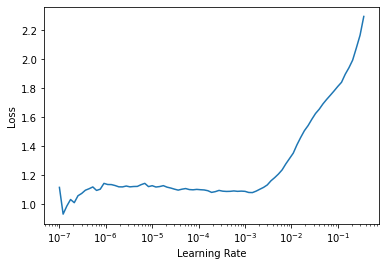

In [16]:
learn.lr_find()

<p>This time the loss curve looks different, as the weights of the network are not random anymore. We do not have this sharp decrease associated with the point where the weights were updated from random to once which decreases the loss. The shape of the curve looks flatter and we will take a range of weights from the point of decrease till the point where the loss starts growing again.</p>
<p>As was mentioned previously the layers transferred from the pre-trained model are already good at recognizing fundamental visual concepts and do not require much training. While deeper layers that are responsible for recognizing complex shapes specific to our project, still will benefit from higher learning rates. Therefore we need to use smaller learning rates for the first layers and bigger learning rates for the last layers, to allow them to fine-tune more quickly than earlier layers. </p>

In [17]:
learn.fit_one_cycle(6, lr_max=slice(1e-7, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.064534,1.033659,0.696252,24:04
1,1.073305,1.028643,0.698379,23:51
2,1.055138,1.021817,0.701268,23:30
3,1.069821,1.015121,0.703234,24:04
4,1.052457,1.010985,0.703836,23:54
5,1.016684,1.010523,0.704197,23:29


<p>Plotting the training and validation loss can help us to evaluate whether we need to continue training. As we can see the validation loss doesn't improve that much anymore, even thought the training loss is still improving. By continuing training we will increase the gap between the training and validation loss which will mean that we overfitted our model. Therefore we better stop the training now.</p>

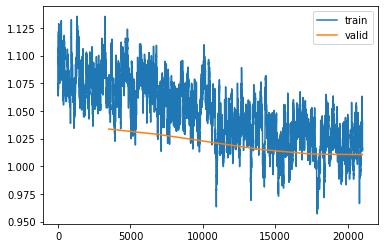

In [18]:
learn.recorder.plot_loss()

<p>We will save our model and classes for future inference.</p>

In [ ]:
modelname = learn.model
modelname.cpu()
torch.save(modelname, 'stage-1_resnet34.pkl')

with open(PATH+CLASSES_PATH, 'w') as f:
    for item in data.vocab:
        f.write("%s\n" % item)

<h2>Evaluation</h2>
<p>It is a time to evaluate the performance of the trained model. The next plot shows the validation accuracy after each epoch of training.</p>

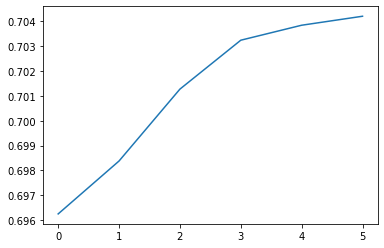

In [19]:
plt.plot(L(learn.recorder.values).itemgot(2))

<h3>Evaluation on the Training Dataset</h3>
<p>First, we will look at the predictions on the training dataset in order to estimate if we still have a high bias.</p>

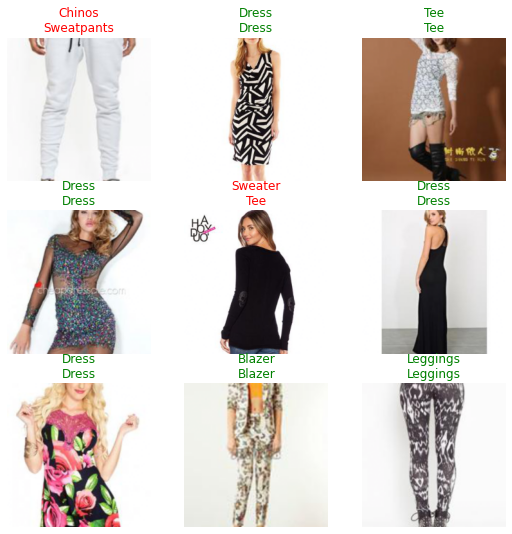

In [20]:
learn.show_results()

<p>Overall, the predictions on the training dataset look good. Our model captures the main concepts.</p>

<h3>Evaluation on the Test Dataset</h3>
<p>Now let's load the test data and check how the model performs on it.</p>

In [22]:
test_img_data = ImageDataLoaders.from_csv(PATH, csv_fname=TEST_PATH,
                                 item_tfms=Resize(224), 
                                 #batch_tfms=Normalize.from_stats(*imagenet_stats),
                                 num_workers=0)

In [23]:
learn.data = test_img_data
learn.validate()

(#2) [1.0105234384536743,0.704197108745575]

<p>The model still shows a good Top-1 Accuracy on the test dataset.</p>

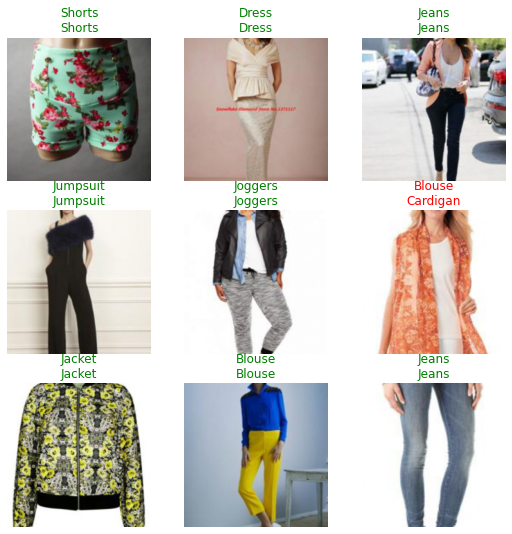

In [24]:
learn.show_results()

<p>Hovewer it misclassifies some objects. Looking closely at misclassified labels we can see that the mistakes that the network made are looking very "human".</p>

<p>The authors of the original paper <a href="https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Liu_DeepFashion_Powering_Robust_CVPR_2016_paper.pdf">DeepFashion: Powering Robust Clothes Recognition and Retrieval with Rich Annotations, CVPR 2016.</a> used Top-3 and Top-5 accuracy for evaluation. We will use the same metrics.</p>

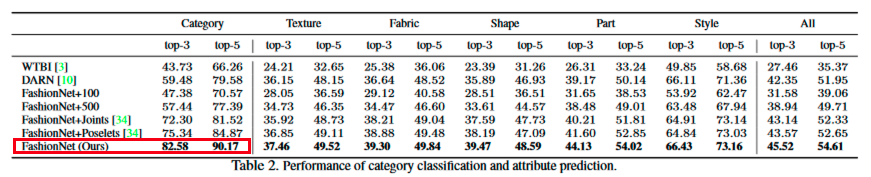

In [25]:
# https://forums.fast.ai/t/return-top-k-accuracy/27658/3
# adjusted to run on PyTorch 1.7.1
def accuracy_topk(output, target, topk=(3,)):
    """Computes the accuracy for the specified values of k"""

    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        #print(correct[:k].contiguous().view(-1))
        correct_k = correct[:k].contiguous().view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [26]:
output, target = learn.get_preds()

<p>The Top-3 accuracy of our model is <b>88.6%</b>, which is <b>6% higher than the benchmark accuracy</b>.</p>

In [27]:
print(accuracy_topk(output=output, target=target))

[TensorCategory([88.9535])]


<p>The Top-5 accuracy of our model is <b>94.1%</b>, which is <b>4% higher than the benchmark accuracy</b>.</p>

In [28]:
print(accuracy_topk(output=output, target=target, topk=(5,)))

[TensorCategory([94.1417])]


<h3>Evaluation on a User Specified Dataset</h3>
<p>Finally we will check how the model works with the user-specified images. I took 98 pictures of my own clothes with the phone camera. Let's load the images and check whether the model can classify them correctly</p>

In [33]:
test_dict = {}
reader = csv.DictReader(open(PATH + CUSTOM_DATASET_PATH))
#reader.next()
for row in reader:
    test_dict[row["image_name"]] = row["category_name"]

In [ ]:
# the cell was not run in a version submitted to the github, to reduce the size of the jupyter notebook
# accuracy in a next step calculated during the previous run
size = 224,224
missclassified_list = []
for key, value in test_dict.items():
    predicted = learn.predict(PATH + key)[0]
    print("Predicted: ", predicted, "True: ", value)
    img=Image.open(PATH + key)
    img.thumbnail(size,Image.ANTIALIAS)
    display(img)
    if predicted != value:
        missclassified_list.append((predicted, value))

In [37]:
print("Accuracy :", 1-len(missclassified_list)/len(test_dict))

Accuracy : 0.6236559139784946


<p>Top-1 Accuracy of the model on the user-specified data is 62% which is lower than on DeepFashion Dataset. However, it is still good for a 46 class classification model. The images in the user dataset are quite different from those on which the model was trained. For example, user images only show a clothes item, while the images in the DeepFashion dataset show a human wearing an item which makes it easier to scale the clothes. Almost all the pants in the user dataset were classified as shorts because it is hard for a model to estimate their lengths relative to the human body. Nevertheless, the model learner the main concepts and could be used in a variety of fashion contexts.</p>